# Analyze data

## Table of Contents
- Number of Race Finishers
- 

In [2]:
# First party libraries
import os

# 3rd Party Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def seconds_to_str(df, tm_field):
    df_copy = df.copy()
    df_copy['tm_hr'] = (df_copy[tm_field] / 3600).apply(np.floor).astype('int')
    df_copy['tm_min'] = ((df_copy[tm_field]-(df_copy['tm_hr']*3600)) / 60).apply(np.floor).astype('int')
    df_copy['tm_sec'] = (df_copy[tm_field] %60).apply(np.floor).astype('int')
    return df_copy['tm_hr'].astype('str') + ':' + df_copy['tm_min'].astype('str') + ':' + \
        df_copy['tm_sec'].astype('str')


### Specify the directory to read from and file to use
Filters read in race results to only ones for 15K distance

In [8]:
data_dir = 'data'
chart_dir = 'charts'
f_name = 'Steamboat_clean_results.pickle'
race_results_all = pd.read_pickle(os.path.join(data_dir, f_name))
race_results = race_results_all.copy()

In [9]:
print(race_results.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13820 entries, 0 to 13819
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   gender        13820 non-null  object
 1   age           13820 non-null  int64 
 2   time          13820 non-null  object
 3   distance      13820 non-null  object
 4   year          13820 non-null  object
 5   time_seconds  13820 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 647.9+ KB
None


In [10]:
race_results.groupby(['year','distance']).agg(finisher_count=('age', 'count'))

finisher_count
year distance                
2016 15K                  821
     4mi                 2346
2017 15K                  665
     4mi                 1781
2018 15K                  655
     4mi                 1848
2019 15K                  545
     4mi                 1491
2021 4mi                  948
2022 15K                  293
     4mi                 1052
2023 15K                  323
     4mi                 1052

Can see number of runners were declining but had a bigger drop after 2019. Even with 2021 only having a 4 mile and no 15K race. 

In [7]:
race_results.groupby(['year','distance','gender']).agg(finisher_count=('age', 'count'))

finisher_count
year distance gender                
2016 15K      F                  363
              M                  458
     4mi      F                 1197
              M                 1149
2017 15K      F                  295
              M                  370
     4mi      F                  887
              M                  894
2018 15K      F                  289
              M                  366
     4mi      F                  932
              M                  916
2019 15K      F                  227
              M                  318
2021 4mi      F                  448
              M                  499
              U                    1
2022 15K      F                  128
              M                  165
     4mi      F                  494
              M                  558
2023 15K      F                  115
              M                  208
     4mi      F                  519
              M                  533

### Create column for age groups of every N years 

In [11]:
age_group_years = 5
if age_group_years == 5:
    conditions = [
        race_results['age'].lt(20),
        race_results['age'].ge(20) & race_results['age'].lt(25),
        race_results['age'].ge(25) & race_results['age'].lt(30),
        race_results['age'].ge(30) & race_results['age'].lt(35),
        race_results['age'].ge(35) & race_results['age'].lt(40),
        race_results['age'].ge(40) & race_results['age'].lt(45),
        race_results['age'].ge(45) & race_results['age'].lt(50),
        race_results['age'].ge(50) & race_results['age'].lt(55),
        race_results['age'].ge(55) & race_results['age'].lt(60),
        race_results['age'].ge(60) & race_results['age'].lt(65),
        race_results['age'].ge(65) & race_results['age'].lt(70),
        race_results['age'].ge(70)
    ]
    choices = ['0 to 19','20 to 24','25 to 29','30 to 34','35 to 39','40 to 44','45 to 49', \
               '50 to 54','55 to 59','60 to 64','65 to 69','70 Over']
else:
    conditions = [
        race_results['age'].lt(20),
        race_results['age'].ge(20) & race_results['age'].lt(30),
        race_results['age'].ge(30) & race_results['age'].lt(40),
        race_results['age'].ge(40) & race_results['age'].lt(50),
        race_results['age'].ge(50) & race_results['age'].lt(60),
        race_results['age'].ge(60) & race_results['age'].lt(70),
        race_results['age'].ge(70)
    ]
    choices = ['0 to 19','20 to 29','30 to 39','40 to 49','50 to 59','60 to 69','70 Over']
race_results['age_group'] = np.select(conditions, choices, default=0)


In [12]:
conditions = [
    race_results['year'].isin(['2016','2017','2018']),
    race_results['year'].isin(['2019','2021','2022','2023'])
]
choices = ['2 loops','3 loops']
race_results['race_course'] = np.select(conditions, choices, default=0)

In [59]:
# The unstack, stack is used to have a record for all age groups for all years and genders
age_grp_det = race_results.groupby(['year','distance','gender','age_group'])\
    .agg(finisher_count=('age', 'count')
         , avg_time_s = ('time_seconds','mean')
         , fastest_time_s = ('time_seconds','min')
         , slowest_time_s = ('time_seconds','max')
         , median_time_s = ('time_seconds','median')
        ).unstack(fill_value=0).unstack(fill_value=0).stack().stack()\
        .sort_values(by=['year','distance','gender']).reset_index()

age_grp_det['avg_time_string'] = seconds_to_str(age_grp_det, 'avg_time_s')
age_grp_det['avg_time_minute'] = age_grp_det['avg_time_s'] /60
age_grp_det['median_time_string'] = seconds_to_str(age_grp_det, 'median_time_s')
age_grp_det['median_time_minute'] = age_grp_det['median_time_s'] /60

age_grp_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                468 non-null    object 
 1   distance            468 non-null    object 
 2   gender              468 non-null    object 
 3   age_group           468 non-null    object 
 4   finisher_count      468 non-null    int64  
 5   avg_time_s          468 non-null    float64
 6   fastest_time_s      468 non-null    int64  
 7   slowest_time_s      468 non-null    int64  
 8   median_time_s       468 non-null    float64
 9   avg_time_string     468 non-null    object 
 10  avg_time_minute     468 non-null    float64
 11  median_time_string  468 non-null    object 
 12  median_time_minute  468 non-null    float64
dtypes: float64(4), int64(3), object(6)
memory usage: 47.7+ KB


# Number of Finishers

## Number of finishers by distance and year

In [65]:
yr_dist_ct = race_results.groupby(['year','distance'])\
    .agg(finisher_count=('age', 'count'))\
    .unstack(fill_value=0).stack()\
    .sort_values(by=['year','distance']).reset_index()

In [66]:
print(yr_dist_ct)

    year distance  finisher_count
0   2016      15K             821
1   2016      4mi            2346
2   2017      15K             665
3   2017      4mi            1781
4   2018      15K             655
5   2018      4mi            1848
6   2019      15K             545
7   2019      4mi            1491
8   2021      15K               0
9   2021      4mi             948
10  2022      15K             293
11  2022      4mi            1052
12  2023      15K             323
13  2023      4mi            1052


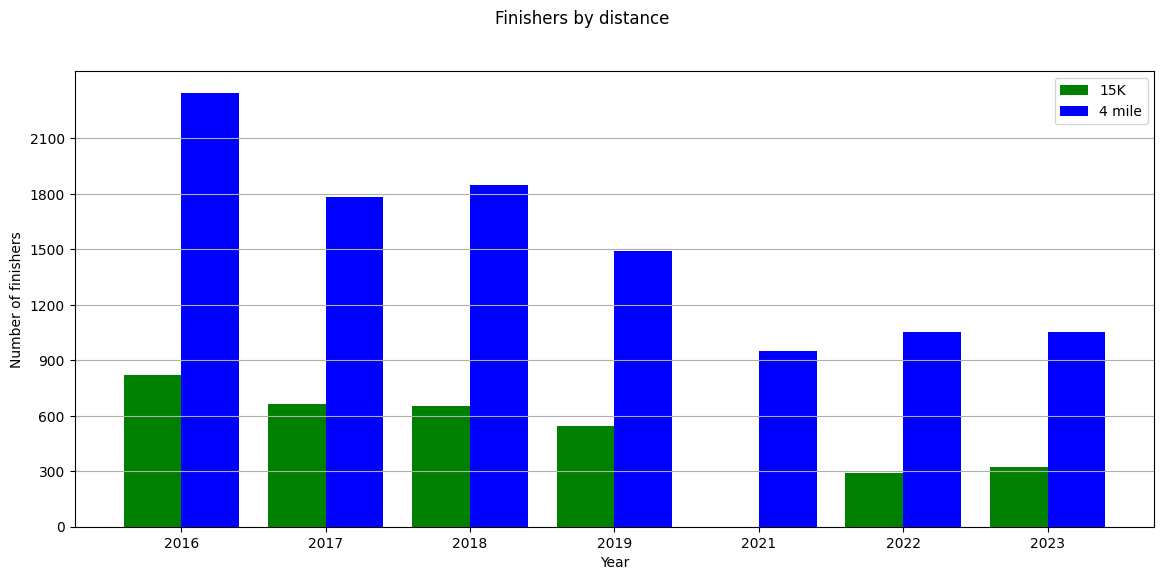

In [76]:
labels = yr_dist_ct['year'].unique()
ct_field = 'finisher_count'

ct_15K = yr_dist_ct[yr_dist_ct['distance']=='15K'][ct_field]
ct_4mi = yr_dist_ct[(yr_dist_ct['distance']=='4mi')][ct_field]

fig, ax = plt.subplots(figsize=(12,6))
bar_width=0.4
xlocs = np.arange(len(labels))

ax.bar(xlocs -bar_width*0.5, ct_15K, bar_width, color='green', label='15K')
ax.bar(xlocs +bar_width*0.5, ct_4mi, bar_width, color='blue', label='4 mile')

ax.set_yticks(range(0, yr_dist_ct['finisher_count'].max()+10, 300))
# ax.set_yticks(range(0,465,100))
    
ax.set_xticks(ticks=range(len(ct_15K)))
ax.set_xticklabels(labels)
ax.yaxis.grid(True)
ax.legend(loc='best')
ax.set_ylabel('Number of finishers')
ax.set_xlabel('Year')
fig.suptitle('Finishers by distance')
fig.tight_layout(pad=2)
fig.savefig(os.path.join(chart_dir, 'Finisher_count_by_distance.png'), dpi=200)


## Number of men and women finishers by distance and year
- There was not a 15K race in 2021

First unstack fills in 0 for any genders that do not have participants for a race, second unstack fills in 0 for any distance that is not present for a year. 


In [60]:
gender_ct = race_results[race_results['gender'].isin(['M','F'])].groupby(['year','distance','gender'])\
    .agg(finisher_count=('age', 'count'))\
    .unstack(fill_value=0).unstack(fill_value=0).stack().stack()\
    .sort_values(by=['year','distance','gender']).reset_index()

In [61]:
print(gender_ct)

    year distance gender  finisher_count
0   2016      15K      F             363
1   2016      15K      M             458
2   2016      4mi      F            1197
3   2016      4mi      M            1149
4   2017      15K      F             295
5   2017      15K      M             370
6   2017      4mi      F             887
7   2017      4mi      M             894
8   2018      15K      F             289
9   2018      15K      M             366
10  2018      4mi      F             932
11  2018      4mi      M             916
12  2019      15K      F             227
13  2019      15K      M             318
14  2019      4mi      F             738
15  2019      4mi      M             753
16  2021      15K      F               0
17  2021      15K      M               0
18  2021      4mi      F             448
19  2021      4mi      M             499
20  2022      15K      F             128
21  2022      15K      M             165
22  2022      4mi      F             494
23  2022      4m

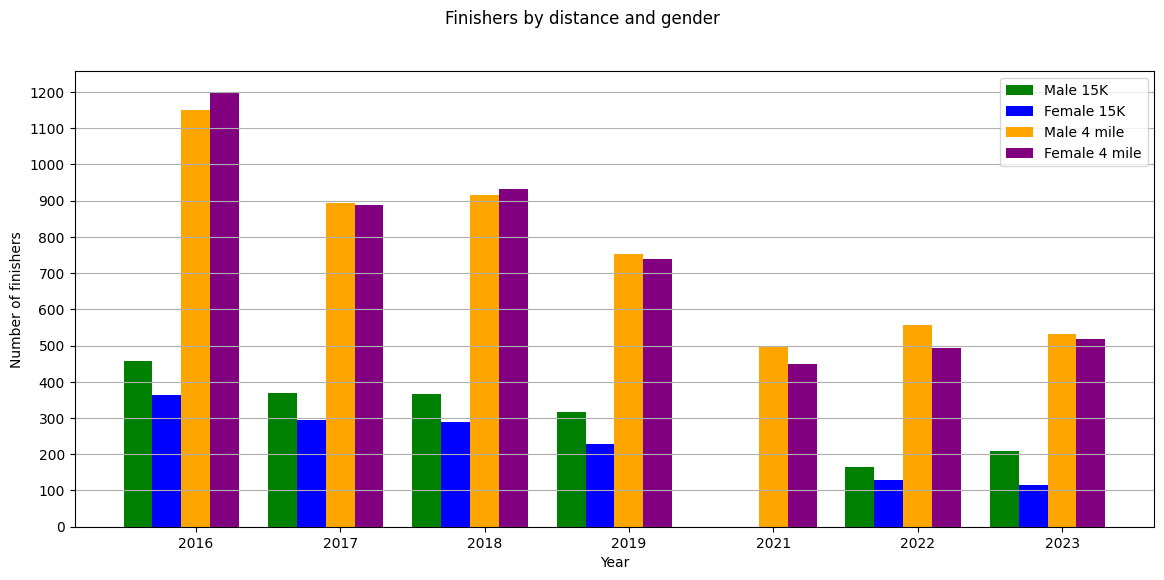

In [62]:
labels = gender_ct['year'].unique()
ct_field = 'finisher_count'
sort_fields = 'year'
men15K_ct_data = gender_ct[(gender_ct['gender']=='M') & (gender_ct['distance']=='15K')]\
    [ct_field]
women15K_ct_data = gender_ct[(gender_ct['gender']=='F') & (gender_ct['distance']=='15K')][ct_field]
men4mi_ct_data = gender_ct[(gender_ct['gender']=='M') & (gender_ct['distance']=='4mi')]\
    [ct_field]
women4mi_ct_data = gender_ct[(gender_ct['gender']=='F') & (gender_ct['distance']=='4mi')]\
    [ct_field]

fig, ax = plt.subplots(figsize=(12,6))
bar_width=0.2
xlocs = np.arange(len(labels))

ax.bar(xlocs -bar_width*2, men15K_ct_data, bar_width, color='green', label='Male 15K')
ax.bar(xlocs -bar_width*1, women15K_ct_data, bar_width, color='blue', label='Female 15K')
ax.bar(xlocs -bar_width*0, men4mi_ct_data, bar_width, color='orange', label='Male 4 mile')
ax.bar(xlocs +bar_width*1, women4mi_ct_data, bar_width, color='purple', label='Female 4 mile')

ax.set_yticks(range(0, gender_ct['finisher_count'].max()+10, 100))
# ax.set_yticks(range(0,465,100))
    
ax.set_xticks(ticks=range(len(men4mi_ct_data)))
ax.set_xticklabels(labels)
ax.yaxis.grid(True)
ax.legend(loc='best')
ax.set_ylabel('Number of finishers')
ax.set_xlabel('Year')
fig.suptitle('Finishers by distance and gender')
fig.tight_layout(pad=2)
fig.savefig(os.path.join(chart_dir, 'Finisher_count_by_distance_gender.png'), dpi=200)


In [78]:
gender_ct.to_csv(os.path.join(data_dir,'Finisher_distance_gender_ct_by_year.csv'))
yr_dist_ct.to_csv(os.path.join(data_dir,'Finisher_distance_ct_by_year.csv'))